## Filter

## Definitions

In [33]:
def percentile_stretch(arr, l = 0.05, h=0.95):
    arr = arr.astype(np.float64).copy()
    ql, qh = np.quantile(arr, l), np.quantile(arr, h)
    arr[arr < ql] = ql
    arr[arr > qh] = qh
    arr = (arr - arr.min()) / (arr.max() - arr.min())
    return arr

In [1]:
import numpy as np
from scipy.ndimage import convolve
import matplotlib.pyplot as plt

def anisotropic_gaussian_kernel(sigma_x, sigma_y, sigma_z, size=None):
    """
    Generate an anisotropic 3D Gaussian kernel.
    
    Parameters:
        sigma_x, sigma_y, sigma_z: Standard deviations along x, y, z axes.
        size: Size of the kernel (optional). If None, it is automatically determined.
    
    Returns:
        kernel: 3D anisotropic Gaussian kernel.
    """
    if size is None:
        # Automatically determine kernel size based on sigmas
        size = [int(2 * np.ceil(3 * s) + 1) for s in [sigma_x, sigma_y, sigma_z]]
    
    # Create a grid of coordinates
    x = np.arange(-(size[0] // 2), size[0] // 2 + 1)
    y = np.arange(-(size[1] // 2), size[1] // 2 + 1)
    z = np.arange(-(size[2] // 2), size[2] // 2 + 1)
    xx, yy, zz = np.meshgrid(x, y, z, indexing='ij')
    
    # Compute the anisotropic Gaussian kernel
    kernel = np.exp(-(xx**2 / (2 * sigma_x**2))\
                      - (yy**2 / (2 * sigma_y**2))\
                      - (zz**2 / (2 * sigma_z**2)))
    kernel /= (2 * np.pi)**1.5 * sigma_x * sigma_y * sigma_z  # Normalize
    return kernel

def anisotropic_gaussian_second_derivatives(sigma_x, sigma_y, sigma_z):
    """
    Generate second-order partial derivatives of the anisotropic Gaussian kernel.
    
    Parameters:
        sigma_x, sigma_y, sigma_z: Standard deviations along x, y, z axes.
        size: Size of the kernel (optional). If None, it is automatically determined.
    
    Returns:
        G_xx, G_yy, G_zz, G_xy, G_xz, G_yz: Second-order partial derivatives.
    """
    # Generate the anisotropic Gaussian kernel
    kernel = anisotropic_gaussian_kernel(sigma_x, sigma_y, sigma_z)

    size_x = int(2 * np.ceil(3 * sigma_x) + 1)
    size_y = int(2 * np.ceil(3 * sigma_y) + 1)
    size_z = int(2 * np.ceil(3 * sigma_z) + 1)
    x = np.arange(-(size_x // 2), size_x // 2 + 1)
    y = np.arange(-(size_y // 2), size_y // 2 + 1)
    z = np.arange(-(size_z // 2), size_z // 2 + 1)
    xx, yy, zz = np.meshgrid(x, y, z, indexing='ij')
    
    # Compute second-order partial derivatives
    G_xx = kernel * (xx**2 / sigma_x**4 - 1 / sigma_x**2)
    G_yy = kernel * (yy**2 / sigma_y**4 - 1 / sigma_y**2)
    G_zz = kernel * (zz**2 / sigma_z**4 - 1 / sigma_z**2)
    G_xy = kernel * (xx * yy / (sigma_x**2 * sigma_y**2))
    G_xz = kernel * (xx * zz / (sigma_x**2 * sigma_z**2))
    G_yz = kernel * (yy * zz / (sigma_y**2 * sigma_z**2))
    
    return G_xx, G_yy, G_zz, G_xy, G_xz, G_yz

def hessian_matrix_anisotropic(image, sigma_x, sigma_y, sigma_z):
    """
    Compute the Hessian matrix of an image using anisotropic Gaussian derivatives.
    
    Parameters:
        image: 3D input image.
        sigma_x, sigma_y, sigma_z: Standard deviations along x, y, z axes.
    
    Returns:
        H_xx, H_xy, H_xz, H_yy, H_yz, H_zz: Components of the Hessian matrix.
    """
    # Get second-order partial derivatives of the anisotropic Gaussian
    G_xx, G_yy, G_zz, G_xy, G_xz, G_yz = anisotropic_gaussian_second_derivatives(sigma_x, sigma_y, sigma_z)
    
    # Convolve the image with the second-order derivatives
    # H_xx = convolve(image, G_xx, mode='constant', cval=0)
    # H_yy = convolve(image, G_yy, mode='constant', cval=0)
    # H_zz = convolve(image, G_zz, mode='constant', cval=0)
    # H_xy = convolve(image, G_xy, mode='constant', cval=0)
    # H_xz = convolve(image, G_xz, mode='constant', cval=0)
    # H_yz = convolve(image, G_yz, mode='constant', cval=0)

    H_xx = convolve(image, G_xx)
    H_yy = convolve(image, G_yy)
    H_zz = convolve(image, G_zz)
    H_xy = convolve(image, G_xy)
    H_xz = convolve(image, G_xz)
    H_yz = convolve(image, G_yz)
    
    return H_xx, H_xy, H_xz, H_yy, H_yz, H_zz

def eigen_decomposition_3d(H_xx, H_xy, H_xz, H_yy, H_yz, H_zz):
    """
    Compute eigenvalues and eigenvectors of a 3D Hessian matrix.
    
    Parameters:
        H_xx, H_xy, H_xz, H_yy, H_yz, H_zz: Components of the 3D Hessian matrix.
    
    Returns:
        eigenvalues: Array of eigenvalues.
        eigenvectors: Array of eigenvectors (as column vectors).
    """
    # Construct the Hessian matrix
    H = np.array([
        [H_xx, H_xy, H_xz],
        [H_xy, H_yy, H_yz],
        [H_xz, H_yz, H_zz]
    ])
    
    # Compute eigenvalues and eigenvectors
    eigenvalues, eigenvectors = np.linalg.eig(H)
    
    return eigenvalues, eigenvectors

def merjeling_filter(img, sigmas, alpha):
    sigma_x, sigma_y, sigma_z = sigmas
    kernel = anisotropic_gaussian_kernel(sigma_x, sigma_y, sigma_z)
    H_xx, H_xy, H_xz, H_yy, H_yz, H_zz = hessian_matrix_anisotropic(img, sigma_x, sigma_y, sigma_z)

    ## Modify the hessians and process
    #Hn_xx = alpha*H_xx + H_yy + H_zz
    #Hn_yy = H_xx + alpha*H_yy + H_zz
    #Hn_zz = H_xx + H_yy + alpha*H_zz

    result = np.zeros_like(img, dtype=np.float64)
    minimum_lam = np.inf

    # Print the shape of the Hessian components
    print("H_xx shape:", H_xx.shape)
    print("H_xy shape:", H_xy.shape)
    print("H_xz shape:", H_xz.shape)
    print("H_yy shape:", H_yy.shape)
    print("H_yz shape:", H_yz.shape)
    print("H_zz shape:", H_zz.shape)

    H = np.array([
        [H_xx, H_xy, H_xz],
        [H_xy, H_yy, H_yz],
        [H_xz, H_yz, H_zz]
    ])  # Shape: (3, 3, H, W, D)

    # Move the matrix dimensions to the end for easier computation
    H = np.moveaxis(H, [0, 1], [-2, -1])  # Shape: (H, W, D, 3, 3)

    # Compute eigenvalues of the Hessian matrix
    eigvals = np.linalg.eigvalsh(H)  # Shape: (H, W, D, 3)
    lambda1, lambda2, lambda3 = eigvals[..., 0], eigvals[..., 1], eigvals[..., 2]

    # Compute modified eigenvalues
    lam1 = lambda1 + alpha * lambda2 + alpha * lambda3
    lam2 = alpha * lambda1 + lambda2 + alpha * lambda3
    lam3 = alpha * lambda1 + alpha * lambda2 + lambda3

    # Compute the maximum eigenvalue at each pixel
    max_lam = np.maximum.reduce([lam1, lam2, lam3])  # Shape: (H, W, D)

    # Initialize the result array
    result = np.zeros_like(img, dtype=np.float64)

    # Set negative values in the result
    result[max_lam < 0] = max_lam[max_lam < 0]

    # Find the minimum of the maximum eigenvalues
    minimum_lam = np.min(max_lam)
    print(f"minimum_lam={minimum_lam}")

    # Normalize the result
    result /= minimum_lam

    return result

    # # Construct Hessian matrix at each pixel
    # H = np.array([[H_xx, H_xy, H_xz], [H_xy, H_yy, H_yz], [H_xz, H_yz, H_zz]])

    # print(f"H shape = {H.shape}")
    
    # # Compute eigenvalues of the Hessian matrix
    # eigvals = np.linalg.eigvalsh(H)  # Eigenvalues are sorted in ascending order
    # lambda1, lambda2, lambda3 = eigvals[..., 0], eigvals[..., 1], eigvals[..., 2]
    # # Compute Meijering response
    # response = (np.abs(lambda3) - np.abs(lambda1)) / (np.abs(lambda3) + np.abs(lambda1) + 1e-6)

    # print(f"reponse shape = {response.shape}")

    # # get maximum at each point
    # result = np.max(response, axis=[0,1])

    

    
    
    # # return
    # # # x,y,z
    # for x in range(img.shape[0]):
    #     for y in range(img.shape[1]):
    #         for z in range(img.shape[2]):
    #             # Extract the modified lambdas
    #             eigenval, _ = eigen_decomposition_3d(H_xx[x,y,z], H_xz[x,y,z], H_xz[x,y,z], H_yy[x,y,z], H_yz[x,y,z], H_zz[x,y,z])
    #             # lam1 = alpha *eigenval[0] + eigenval[1] + eigenval[2]
    #             # lam2 = alpha *eigenval[1] + eigenval[0] + eigenval[2]
    #             # lam3 = alpha *eigenval[2] + eigenval[1] + eigenval[0]


    #             lam1 = eigenval[0] + alpha*eigenval[1] + alpha*eigenval[2]
    #             lam2 = alpha*eigenval[0] + eigenval[1] + alpha*eigenval[2]
    #             lam3 = alpha*eigenval[0] + alpha*eigenval[1] + eigenval[2]

    #             max_lam = max(lam1, lam2, lam3)
                
    #             minimum_lam = min(max_lam, minimum_lam)
    #             if max_lam < 0:
    #                 result[x,y,z]=max_lam
    #             else:
    #                 result[x,y,z]=0

    # print(f"minimum_lam={minimum_lam}")

    # # divide
    # result /= minimum_lam
    # return result


H_xx shape: (64, 64, 64)
H_xy shape: (64, 64, 64)
H_xz shape: (64, 64, 64)
H_yy shape: (64, 64, 64)
H_yz shape: (64, 64, 64)
H_zz shape: (64, 64, 64)
H_xx shape: (64, 64, 64)
H_xy shape: (64, 64, 64)
H_xz shape: (64, 64, 64)
H_yy shape: (64, 64, 64)
H_yz shape: (64, 64, 64)
H_zz shape: (64, 64, 64)
minimum_lam=-0.03780728344804211


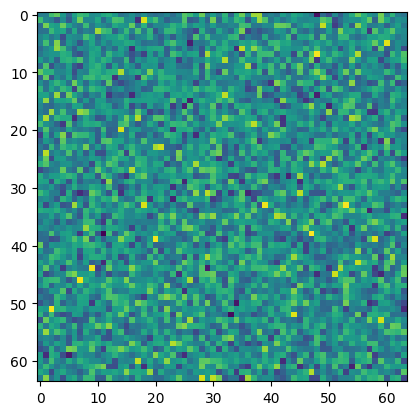

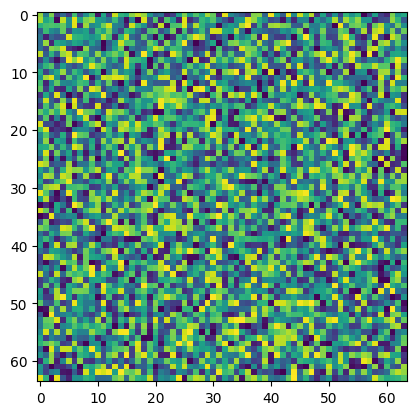

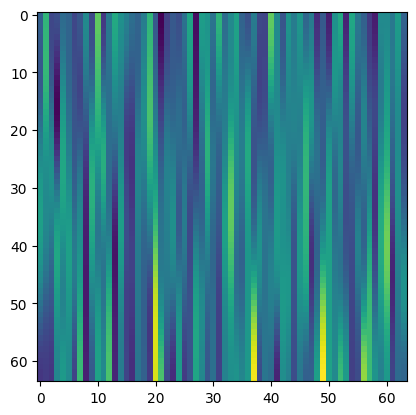

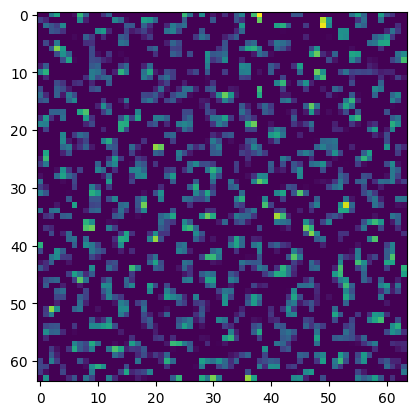

In [2]:
# Example usage
if __name__ == "__main__":
    # Load or create a 3D image (replace this with your image)
    image = np.random.rand(64, 64, 64)  # Example 3D image
    
    # Define anisotropic standard deviations
    sigma_x, sigma_y, sigma_z = 10.0, 0.1, 0.1


    kernel = anisotropic_gaussian_kernel(sigma_x, sigma_y, sigma_z)

    convolved = convolve(image, kernel, mode='reflect')

    plt.figure()
    plt.imshow(convolved[0])


    plt.figure()
    plt.imshow(image[0])

    plt.figure()
    plt.imshow(convolved[:,:,0])


    # Now do the Hessians2
    
    # # Compute the Hessian matrix components
    H_xx, H_xy, H_xz, H_yy, H_yz, H_zz = hessian_matrix_anisotropic(image, sigma_x, sigma_y, sigma_z)
    
    # Print the shape of the Hessian components
    print("H_xx shape:", H_xx.shape)
    print("H_xy shape:", H_xy.shape)
    print("H_xz shape:", H_xz.shape)
    print("H_yy shape:", H_yy.shape)
    print("H_yz shape:", H_yz.shape)
    print("H_zz shape:", H_zz.shape)

    result = merjeling_filter(image, [10.0, 1.0, 1.0], 1/3)
    plt.figure()
    plt.imshow(result[0])



In [3]:
result.min()

np.float64(-0.0)

In [4]:
result.max()

np.float64(1.0)

# Our data

In [5]:
import skimage

In [6]:
raw_data = skimage.io.imread('180322_Sqh-mCh Tub-GFP 16h_110_time-10.tif.files.tif')

In [7]:
sigma = 2
filtered = merjeling_filter(raw_data.astype(np.float64), [sigma / 7, sigma, sigma], 1/3)


H_xx shape: (7, 512, 512)
H_xy shape: (7, 512, 512)
H_xz shape: (7, 512, 512)
H_yy shape: (7, 512, 512)
H_yz shape: (7, 512, 512)
H_zz shape: (7, 512, 512)
minimum_lam=-20219.924354305298


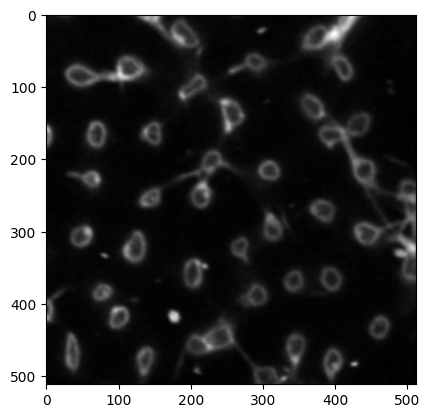

In [8]:
plt.figure()
plt.imshow(filtered[0], 'gray')

H_xx shape: (7, 512, 512)
H_xy shape: (7, 512, 512)
H_xz shape: (7, 512, 512)
H_yy shape: (7, 512, 512)
H_yz shape: (7, 512, 512)
H_zz shape: (7, 512, 512)
minimum_lam=-883.2284644459386


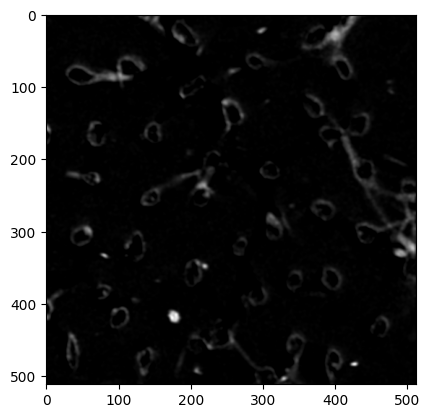

In [9]:
sigma = 2
filtered = merjeling_filter(raw_data.astype(np.float64), [sigma / 2, sigma, sigma], 2/3)
plt.figure()
plt.imshow(filtered[0], 'gray')

H_xx shape: (7, 512, 512)
H_xy shape: (7, 512, 512)
H_xz shape: (7, 512, 512)
H_yy shape: (7, 512, 512)
H_yz shape: (7, 512, 512)
H_zz shape: (7, 512, 512)
minimum_lam=-32302.033630260583


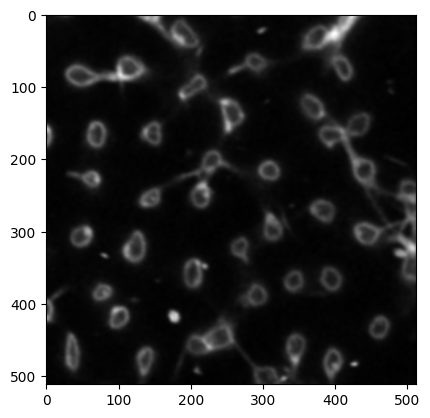

In [10]:
sigma = 2
filtered = merjeling_filter(raw_data.astype(np.float64), [sigma / 9, sigma, sigma], 1/4)
plt.figure()
plt.imshow(filtered[0], 'gray')

In [11]:
filtered.max()

np.float64(1.0)

In [12]:
filtered.min()

np.float64(0.07244999993881307)

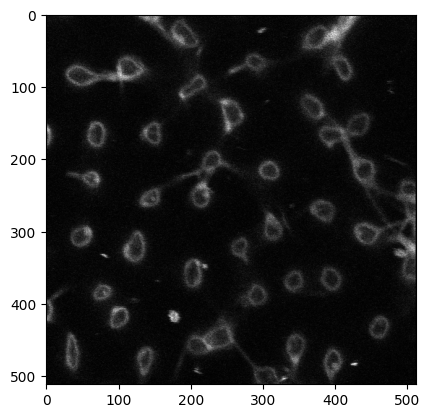

In [13]:
plt.imshow(raw_data[0], 'gray')

H_xx shape: (7, 512, 512)
H_xy shape: (7, 512, 512)
H_xz shape: (7, 512, 512)
H_yy shape: (7, 512, 512)
H_yz shape: (7, 512, 512)
H_zz shape: (7, 512, 512)
minimum_lam=-2829.5702916014707


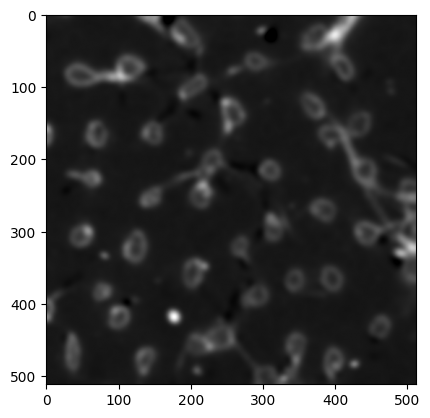

In [14]:
sigma = 4
filtered = merjeling_filter(raw_data.astype(np.float64), [sigma / 9, sigma, sigma], 1/4)
plt.figure()
plt.imshow(filtered[0], 'gray')

H_xx shape: (7, 512, 512)
H_xy shape: (7, 512, 512)
H_xz shape: (7, 512, 512)
H_yy shape: (7, 512, 512)
H_yz shape: (7, 512, 512)
H_zz shape: (7, 512, 512)
minimum_lam=-1308.9620633244497


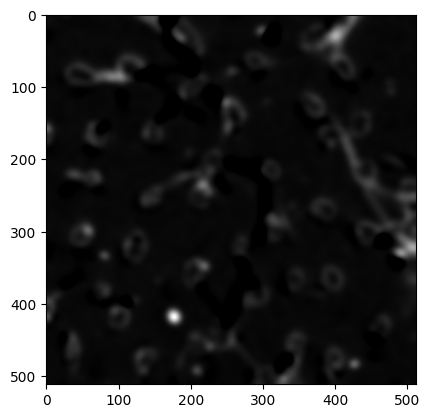

In [15]:
sigma = 5
filtered = merjeling_filter(raw_data.astype(np.float64), [sigma / 9, sigma, sigma], 1/4)
plt.figure()
plt.imshow(filtered[0], 'gray')

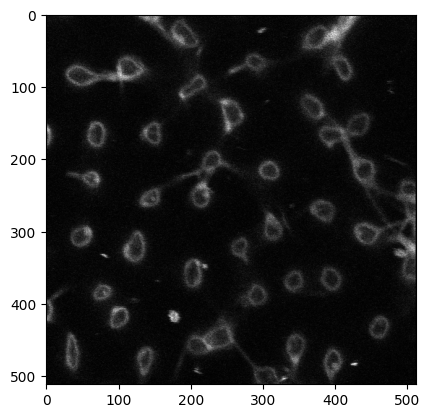

In [16]:
plt.imshow(raw_data[0], 'gray')

## Multiscale approach

### Preprocessing

In [34]:
data = percentile_stretch(raw_data, 0.1, 0.9)

### Filtering

In [35]:
# Different scales
scales = [0.25, 0.5, 1, 2, 3, 4, 5, 6]
results = []
print(f"All scales: {scales}")
for scale in scales:
    print(f"scale={scale}")
    results.append(merjeling_filter(data, [scale / 9, scale, scale], 1/4))

All scales: [0.25, 0.5, 1, 2, 3, 4, 5, 6]
scale=0.25
H_xx shape: (7, 512, 512)
H_xy shape: (7, 512, 512)
H_xz shape: (7, 512, 512)
H_yy shape: (7, 512, 512)
H_yz shape: (7, 512, 512)
H_zz shape: (7, 512, 512)
minimum_lam=-12589.91312106887
scale=0.5
H_xx shape: (7, 512, 512)
H_xy shape: (7, 512, 512)
H_xz shape: (7, 512, 512)
H_yy shape: (7, 512, 512)
H_yz shape: (7, 512, 512)
H_zz shape: (7, 512, 512)
minimum_lam=-603.6815002114465
scale=1
H_xx shape: (7, 512, 512)
H_xy shape: (7, 512, 512)
H_xz shape: (7, 512, 512)
H_yy shape: (7, 512, 512)
H_yz shape: (7, 512, 512)
H_zz shape: (7, 512, 512)
minimum_lam=-72.68621834023658
scale=2
H_xx shape: (7, 512, 512)
H_xy shape: (7, 512, 512)
H_xz shape: (7, 512, 512)
H_yy shape: (7, 512, 512)
H_yz shape: (7, 512, 512)
H_zz shape: (7, 512, 512)
minimum_lam=-9.074857518501403
scale=3
H_xx shape: (7, 512, 512)
H_xy shape: (7, 512, 512)
H_xz shape: (7, 512, 512)
H_yy shape: (7, 512, 512)
H_yz shape: (7, 512, 512)
H_zz shape: (7, 512, 512)
minimum_l

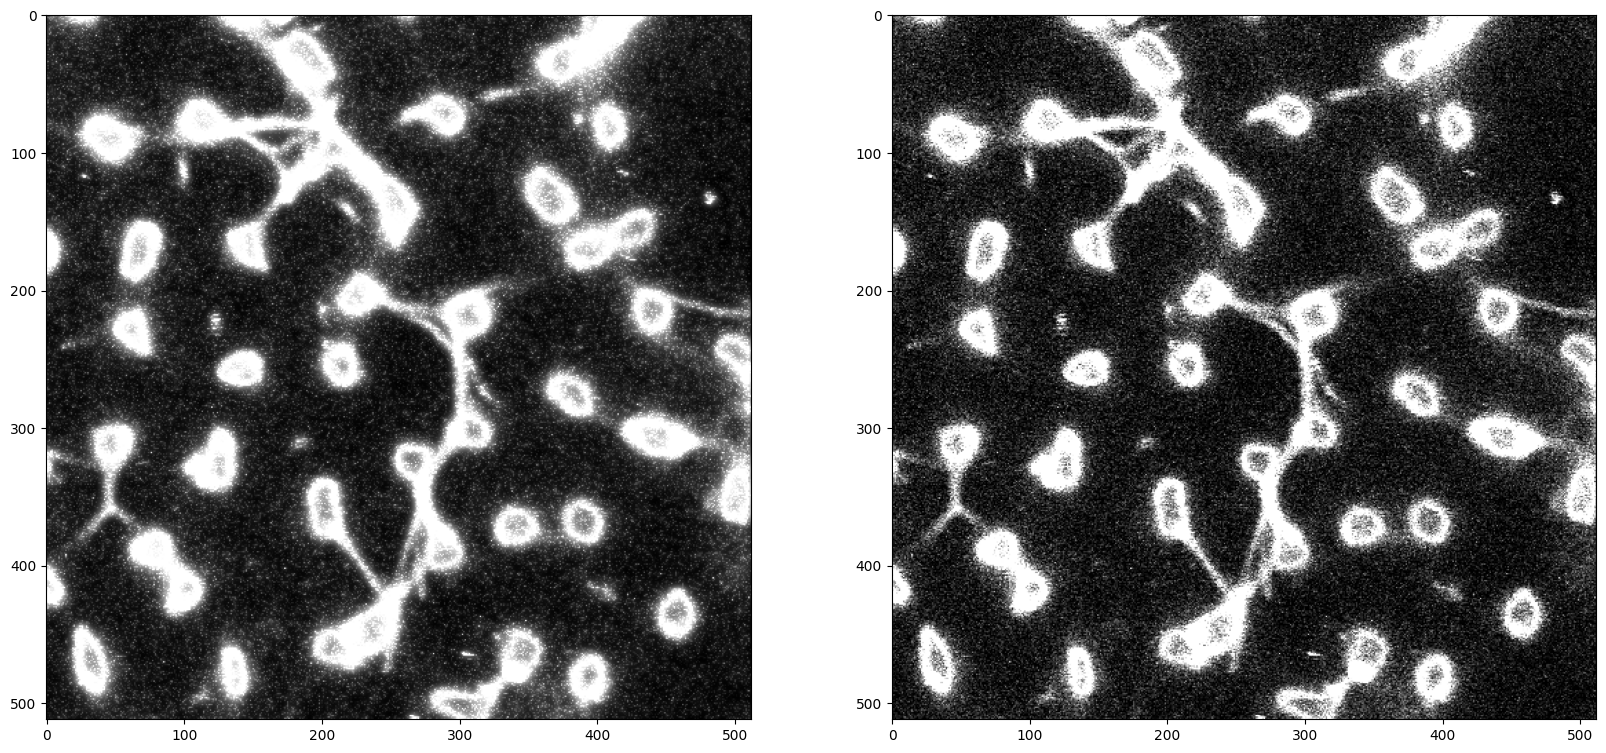

In [50]:
# Multiscale join
multiscale = np.array(results)
fig, ax = plt.subplots(ncols=2, figsize=(20, 10))
ax[0].imshow(multiscale.max(axis=0)[2], 'gray')
ax[1].imshow(data[2], 'gray')

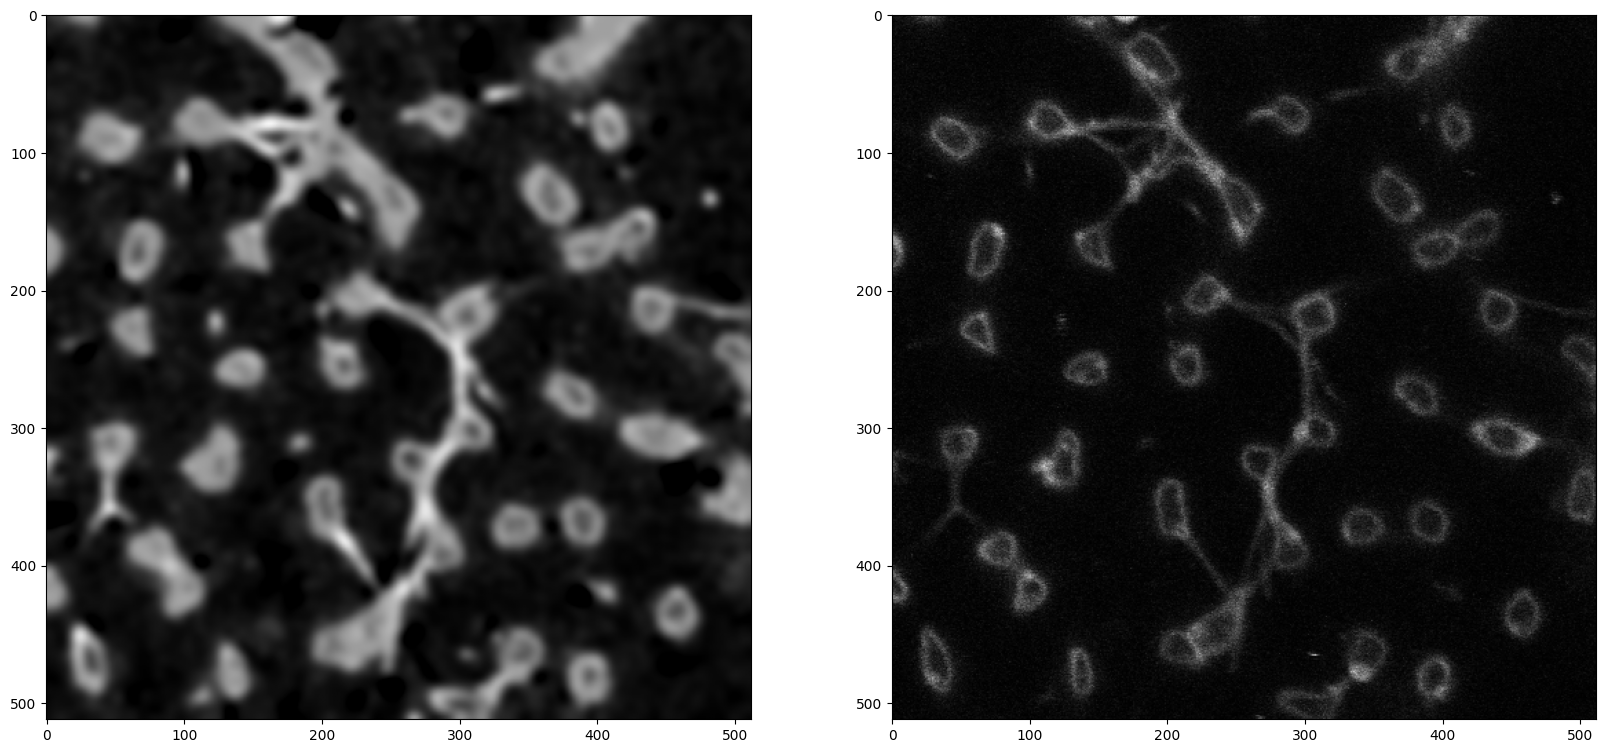

In [51]:
# Multiscale join
multiscale = np.array(results)
fig, ax = plt.subplots(ncols=2, figsize=(20,10))
ax[0].imshow(multiscale[-3,2], 'gray')
ax[1].imshow(raw_data[2], 'gray')

### Post processing